In [1]:
!pip install -q kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setup kaggle so that dataset could be fetched from colab.

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

Downloading medical MNIST dataset.

In [6]:
!kaggle datasets download andrewmvd/medical-mnist

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/medical-mnist
License(s): other
  0% 0.00/84.8M [00:00<?, ?B/s]
100% 84.8M/84.8M [00:00<00:00, 967MB/s]


In [7]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


Unzip data set

In [8]:
import zipfile

image_path = "medical-mnist.zip"
data_path = "data/"
with zipfile.ZipFile(image_path, "r") as zip_ref:
  print("Unzipping medical-mnist data....")
  zip_ref.extractall(data_path)

Unzipping medical-mnist data....


In [9]:
import os

def walk_through_dir(dir_path):
  """ Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

walk_through_dir(data_path)

There are 6 directories and 0 images in 'data/'
There are 0 directories and 10000 images in 'data/Hand'
There are 0 directories and 10000 images in 'data/CXR'
There are 0 directories and 10000 images in 'data/AbdomenCT'
There are 0 directories and 8954 images in 'data/BreastMRI'
There are 0 directories and 10000 images in 'data/HeadCT'
There are 0 directories and 10000 images in 'data/ChestCT'


Splitting data into train, test and validate directories, with class names as subdirectories, since this is the structure that is expected by PyTorch. After splitting, we expect that each eg. hand image will be in 'Hand' subdirectory of train, or test, or validate directory.

In [10]:
import os
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math

def split_dataset(source_dir, dest_dir, train_ratio=0.7, test_ratio=0.2, val_ratio=0.1):
    """
    Splits an image dataset into train, test, and validation sets.

    Args:
        source_dir (str): Path to the directory containing class subfolders.
        dest_dir (str): Path to the destination directory where 'train', 'test',
                        and 'val' subfolders will be created.
        train_ratio (float): Ratio of images for the training set (e.g., 0.7).
        test_ratio (float): Ratio of images for the testing set (e.g., 0.2).
        val_ratio (float): Ratio of images for the validation set (e.g., 0.1).
    """
    if not (math.isclose(train_ratio + test_ratio + val_ratio, 1.0)):
        raise ValueError("Train, test, and validation ratios must sum to 1.0")

    # Define paths for the split directories
    train_dir = os.path.join(dest_dir, 'train')
    test_dir = os.path.join(dest_dir, 'test')
    val_dir = os.path.join(dest_dir, 'val')

    # Create top-level split directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Get all class subfolders
    class_names = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    if not class_names:
        print(f"No subfolders (classes) found in {source_dir}. Please check your source directory structure.")
        return

    print(f"Found {len(class_names)} classes: {', '.join(class_names)}")

    total_train_images = 0
    total_test_images = 0
    total_val_images = 0

    # Loop through each class subfolder
    for class_name in class_names:
        class_source_path = os.path.join(source_dir, class_name)
        images = [f for f in os.listdir(class_source_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
        random.shuffle(images) # Shuffle images for random split

        num_images = len(images)
        if num_images == 0:
            print(f"Warning: Class '{class_name}' has no images. Skipping.")
            continue

        num_train = int(num_images * train_ratio)
        num_test = int(num_images * test_ratio)
        num_val = num_images - num_train - num_test # Ensure all images are distributed

        print(f"Class '{class_name}': Total {num_images} images | Train: {num_train}, Test: {num_test}, Val: {num_val}")

        # Split images
        train_images = images[:num_train]
        total_train_images += len(train_images)
        test_images = images[num_train : num_train + num_test]
        total_test_images += len(test_images)
        val_images = images[num_train + num_test : num_train + num_test + num_val]
        total_val_images += len(val_images)

        # Create class subdirectories in train, test, val folders
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        # Copy images to their respective destinations
        for img_name in train_images:
            src_path = os.path.join(class_source_path, img_name)
            dest_path = os.path.join(train_dir, class_name, img_name)
            shutil.copy(src_path, dest_path)

        for img_name in test_images:
            src_path = os.path.join(class_source_path, img_name)
            dest_path = os.path.join(test_dir, class_name, img_name)
            shutil.copy(src_path, dest_path)

        for img_name in val_images:
            src_path = os.path.join(class_source_path, img_name)
            dest_path = os.path.join(val_dir, class_name, img_name)
            shutil.copy(src_path, dest_path)

    print("\nDataset splitting complete!")
    print(f"Structure created under: {dest_dir}")
    print(f"Train images in: {os.path.join(dest_dir, 'train')}")
    print(f"Test images in: {os.path.join(dest_dir, 'test')}")
    print(f"Validation images in: {os.path.join(dest_dir, 'val')}")

    return total_train_images, total_test_images, total_val_images

In [11]:
image_path = "data/medical-mnist"
data_path = "data"
total_train_images, total_test_images, total_val_images = split_dataset(data_path, image_path, train_ratio=0.7, test_ratio=0.2, val_ratio=0.1)

Found 7 classes: Hand, CXR, medical-mnist, AbdomenCT, BreastMRI, HeadCT, ChestCT
Class 'Hand': Total 10000 images | Train: 7000, Test: 2000, Val: 1000
Class 'CXR': Total 10000 images | Train: 7000, Test: 2000, Val: 1000
Class 'AbdomenCT': Total 10000 images | Train: 7000, Test: 2000, Val: 1000
Class 'BreastMRI': Total 8954 images | Train: 6267, Test: 1790, Val: 897
Class 'HeadCT': Total 10000 images | Train: 7000, Test: 2000, Val: 1000
Class 'ChestCT': Total 10000 images | Train: 7000, Test: 2000, Val: 1000

Dataset splitting complete!
Structure created under: data/medical-mnist
Train images in: data/medical-mnist/train
Test images in: data/medical-mnist/test
Validation images in: data/medical-mnist/val


In [12]:
walk_through_dir(image_path)

There are 3 directories and 0 images in 'data/medical-mnist'
There are 6 directories and 0 images in 'data/medical-mnist/val'
There are 0 directories and 1000 images in 'data/medical-mnist/val/Hand'
There are 0 directories and 1000 images in 'data/medical-mnist/val/CXR'
There are 0 directories and 1000 images in 'data/medical-mnist/val/AbdomenCT'
There are 0 directories and 897 images in 'data/medical-mnist/val/BreastMRI'
There are 0 directories and 1000 images in 'data/medical-mnist/val/HeadCT'
There are 0 directories and 1000 images in 'data/medical-mnist/val/ChestCT'
There are 6 directories and 0 images in 'data/medical-mnist/test'
There are 0 directories and 2000 images in 'data/medical-mnist/test/Hand'
There are 0 directories and 2000 images in 'data/medical-mnist/test/CXR'
There are 0 directories and 2000 images in 'data/medical-mnist/test/AbdomenCT'
There are 0 directories and 1790 images in 'data/medical-mnist/test/BreastMRI'
There are 0 directories and 2000 images in 'data/med

Randomly selected image path: data/medical-mnist/train/Hand/004104.jpeg
Extracted image class: Hand


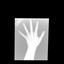

In [13]:
from pathlib import Path
from PIL import Image
from typing import List, Tuple

# Define the root directory containing 'train' and 'test'
image_path = Path("data/medical-mnist")
train_dir = image_path / "train"
test_dir = image_path / "test"

def get_random_image_path(directory: Path=None) -> Tuple[Path, str]:
  """
  Recursively finds all image files (with .jpeg extension) in the given directory
  and returns a randomly selected image path and its class name.

  Args:
      directories (List[Path]): A list of Path objects representing the directory to search.

  Returns:
      Tuple[Path, str]: A tuple containing the path to a random image and its class name.
  """
  if directory is None:
    directory = train_dir
  # Get a list of all image paths within directory
  all_image_paths = list(directory.rglob("*.jpeg"))

  # Select a random image path
  random_image_path = random.choice(all_image_paths)

  # Extract the image class from the parent directory name
  image_class = random_image_path.parent.name

  print(f"Randomly selected image path: {random_image_path}")
  print(f"Extracted image class: {image_class}")

  return random_image_path, image_class


def get_random_image(directory: Path=None) -> Image.Image:
  """
  Opens a random image from the specified directories and returns it as a PIL Image object.

  Args:
      directories (Path): Path to the input image file.
  """
  random_image_path, image_class = get_random_image_path(directory)
  img = Image.open(random_image_path)

  return img


img = get_random_image()
img

Randomly selected image path: data/medical-mnist/val/CXR/000092.jpeg
Extracted image class: CXR


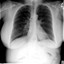

In [25]:
data_root = Path("data/medical-mnist")
validate_dir = data_root / "val"

img = get_random_image(validate_dir)
img

Run few more times, until some low quality image is shown

Randomly selected image path: data/medical-mnist/train/ChestCT/005847.jpeg
Extracted image class: ChestCT


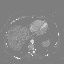

In [26]:
img = get_random_image()
img

Let's pick out the image that was of less quality and try out some enhancement techniques to see if we can get better contrast.  

Low quality image path: data/medical-mnist/train/ChestCT/005847.jpeg


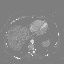

In [27]:
low_quality_image_path = img.filename
print(f"Low quality image path: {low_quality_image_path}")
img = Image.open(low_quality_image_path)
img

This next part is handling enhancement techniques.

In [28]:
import cv2

def visualize_enhancement(image_path, enhancement_function, title_original="Original Image", title_enhanced="Enhanced Image"):
    """
    Loads an image, applies an enhancement function, and plots the original
    and enhanced images side-by-side.

    Args:
        image_path (str): Path to the input image file.
        enhancement_function (callable): A function that takes a grayscale
                                         NumPy array (image) and returns an
                                         enhanced grayscale NumPy array.
        title_original (str): Title for the original image subplot.
        title_enhanced (str): Title for the enhanced image subplot.
    """
    try:
        # Load image in grayscale using OpenCV
        original_img_np = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if original_img_np is None:
            print(f"Error: Could not load image from {image_path}. Please check the path.")
            return

        # Apply the enhancement function
        enhanced_img_np = enhancement_function(original_img_np)

        # Plotting
        plt.figure(figsize=(4,4))

        plt.subplot(1, 2, 1)
        plt.imshow(original_img_np, cmap='gray')
        plt.title(title_original)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(enhanced_img_np, cmap='gray')
        plt.title(title_enhanced)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred during visualization: {e}")


Visualizing Histogram Equalization...


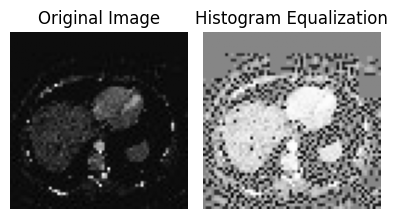

In [29]:
print("\nVisualizing Histogram Equalization...")
def histogram_equalization(img_np):
  return cv2.equalizeHist(img_np)

visualize_enhancement(
  low_quality_image_path,
  histogram_equalization,
  title_enhanced="Histogram Equalization"
)


Visualizing CLAHE...


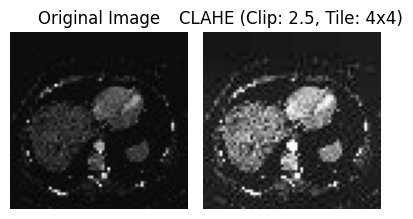

In [30]:
print("\nVisualizing CLAHE...")
def clahe_enhancement(img_np, clip_limit=2.5, tile_grid_size=(4,4)):
  clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
  return clahe.apply(img_np)

visualize_enhancement(
  low_quality_image_path,
  lambda img: clahe_enhancement(img, clip_limit=2.5, tile_grid_size=(4,4)),
  title_enhanced="CLAHE (Clip: 2.5, Tile: 4x4)"
)


Visualizing Custom Linear Stretching...


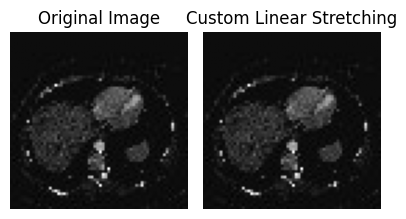

In [31]:
print("\nVisualizing Custom Linear Stretching...")
def linear_stretching(img_np):
  min_val = np.min(img_np)
  max_val = np.max(img_np)
  if max_val == min_val: # Avoid division by zero for uniform images
    return img_np
  stretched_img = ((img_np - min_val) / (max_val - min_val)) * 255
  return stretched_img.astype(np.uint8)

visualize_enhancement(
  low_quality_image_path,
  linear_stretching,
  title_enhanced="Custom Linear Stretching"
)


Custom enhancement from https://towardsdatascience.com/contrast-enhancement-of-grayscale-images-using-morphological-operators-de6d483545a1/


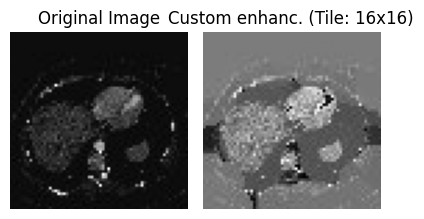

In [32]:
print("\nCustom enhancement from https://towardsdatascience.com/contrast-enhancement-of-grayscale-images-using-morphological-operators-de6d483545a1/")
def custom_enhancement(img_np, tile_grid_size=(4,4)):
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,tile_grid_size)
  low_quality_image_np = cv2.imread(low_quality_image_path, cv2.IMREAD_GRAYSCALE)
  topHat = cv2.morphologyEx(low_quality_image_np, cv2.MORPH_TOPHAT, kernel)
  blackHat = cv2.morphologyEx(low_quality_image_np, cv2.MORPH_BLACKHAT, kernel)
  enhacement = low_quality_image_np + topHat - blackHat
  return enhacement

visualize_enhancement(
  low_quality_image_path,
  lambda img: custom_enhancement(img, tile_grid_size=(16,16)),
  title_enhanced="Custom enhanc. (Tile: 16x16)"
)

Seams that CLAHE looks the best, let's check on some more images.

Randomly selected image path: data/medical-mnist/train/ChestCT/008561.jpeg
Extracted image class: ChestCT


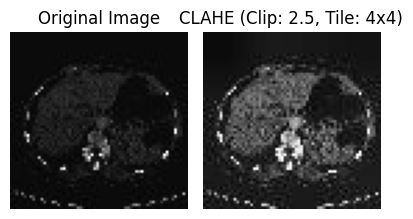

In [40]:
img_path, image_class = get_random_image_path()
visualize_enhancement(
  img_path,
  lambda img: clahe_enhancement(img, clip_limit=2.5, tile_grid_size=(4,4)),
  title_enhanced="CLAHE (Clip: 2.5, Tile: 4x4)"
)

Now that image contrast look better, let's find classes of image data by fetching each subdirectory name in train or test directory.

In [41]:
from typing import Tuple, Dict, List

# Finds classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("medical_mnist/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [42]:
find_classes(train_dir)

(['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT'],
 {'AbdomenCT': 0,
  'BreastMRI': 1,
  'CXR': 2,
  'ChestCT': 3,
  'Hand': 4,
  'HeadCT': 5})

In [43]:
find_classes(test_dir)

(['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT'],
 {'AbdomenCT': 0,
  'BreastMRI': 1,
  'CXR': 2,
  'ChestCT': 3,
  'Hand': 4,
  'HeadCT': 5})

Next step is turning image data into a Dataset that is used with PyTorch. Custom dataset is used, this is mostly because of the OpenCV contrast enhancement (CLAHE), without this part, simple torchvision.datasets.ImageFolder could be used.

In [44]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
import os
from typing import Tuple, Dict, List

class CustomMedicalImageDataset(torch.utils.data.Dataset):
    def __init__(self, directory, transform=None):
        """
        Args:
            directory (str or Path): Directory with class subfolders containing images.
            transform (callable, optional): Optional transform to be applied
                                            on a sample.
        """
        self.directory = directory
        self.transform = transform
        self.image_paths, self.labels, self.classes = self._load_image_paths_and_labels()

    def _load_image_paths_and_labels(self) -> Tuple[List[str], List[int], List[str]]:
        """Collects image paths and corresponding labels from the directory."""
        image_paths = []
        labels = []
        classes = sorted(entry.name for entry in os.scandir(self.directory) if entry.is_dir())

        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {self.directory}.")

        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        for class_name in classes:
            class_dir = os.path.join(self.directory, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                    image_paths.append(os.path.join(class_dir, img_name))
                    labels.append(class_to_idx[class_name])

        return image_paths, labels, classes


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # 1. Load image with OpenCV
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Load as grayscale

        if img is None:
            print(f"Warning: Could not load image from {img_path}. Skipping.")
            # Return a dummy tensor and label or handle as an error
            # Here we'll return a zero tensor and a placeholder label (e.g., -1)
            return torch.zeros(1, 64, 64), -1 # Assuming images are 64x64

        # 2. Apply OpenCV contrast enhancement (CLAHE)
        # Check if the image is not empty before applying CLAHE
        # Using CLAHE parameters as found in tests above
        if img.size > 0:
            clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(4,4))
            img_enhanced = clahe.apply(img)
        else:
             img_enhanced = img # Use original empty image if it's empty

        # 3. Convert to PIL Image for torchvision transforms
        img_pil = Image.fromarray(img_enhanced)

        # 4. Apply PyTorch transforms (including ToTensor)
        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = transforms.ToTensor()(img_pil) # Default if no transform

        return img_tensor, label

    # This is a helper function later used to plot original images with the ones
    # transformed
    def get_random_samples_for_display(self, num_samples: int = 5):
        """
        Fetches a specified number of random original image paths and
        their corresponding processed (enhanced) image tensors from the dataset.

        Args:
            num_samples (int): The number of random samples to fetch.

        Returns:
            tuple: A tuple containing two lists:
                   - list of original image file paths (str)
                   - list of processed image tensors (torch.Tensor)
        """
        if num_samples <= 0:
            raise ValueError("num_samples must be a positive integer.")
        if num_samples > len(self):
            print(f"Warning: num_samples ({num_samples}) is greater than "
                  f"the dataset size ({len(self)}). Returning all {len(self)} samples.")
            num_samples = len(self)

        random_indices = random.sample(range(len(self)), num_samples)

        original_paths = []
        processed_images = []

        for idx in random_indices:
            # Get the original image path
            original_path = os.path.join(self.image_paths[idx])
            original_paths.append(original_path)

            # Get the processed image tensor from __getitem__
            processed_image_tensor, _ = self[idx]
            processed_images.append(processed_image_tensor)

        return original_paths, processed_images

Let's create some transforms to prepare our images.

In [45]:
data_transforms = transforms.Compose([
    # No need to resize here as images are already 64x64
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    transforms.Normalize(mean=[0.5], std=[0.5]) # Standard normalization for grayscale
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    transforms.Normalize(mean=[0.5], std=[0.5]) # Standard normalization for grayscale
])

And finally loading train and test images into Dataset.

In [46]:
from torchvision import datasets
from pathlib import Path

data_root = Path("data/medical-mnist")
train_dir = data_root / "train"
test_dir = data_root / "test"

train_data_custom = CustomMedicalImageDataset(directory=train_dir, # target folder of images
                                      transform=data_transforms) # transforms to perform on data (images)

test_data_custom = CustomMedicalImageDataset(directory=test_dir,
                                      transform=test_transform)

print(f"Train data:\n{train_data_custom}\nTest data:\n{test_data_custom}")

Train data:
Test data:


In [47]:
len(train_data_custom), len(test_data_custom)

(41267, 11790)

In [51]:
total_train_images
# Check for equality amongst our custom Dataset and number of images that are in directories
print((len(train_data_custom) == total_train_images) and (len(test_data_custom) == total_test_images))

True


Let's check the images from the custom dataset.

In [52]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n: int = 10,
                          display_shape: bool = True):
  if n > 10:
    n = 10
    display_shape = False
    print("For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Loop through random idx and plot them with matplotlib
  plt.figure(figsize=(16,8))
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust, cmap='gray')
    plt.axis("off")
    if classes:
        title = f"class: {classes[targ_label]}"
        if display_shape:
            title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

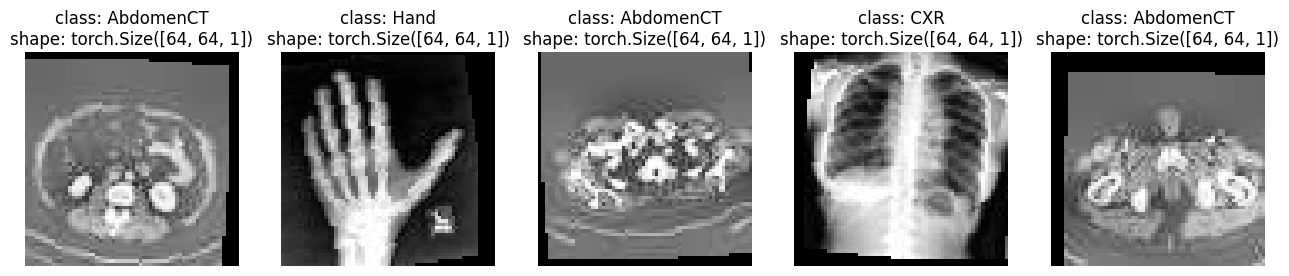

In [64]:
# Display random images from the CustomMedicalImageDataset Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=train_data_custom.classes) # Try setting the seed for reproducible images

Let's see how the transformation changed the original image.

In [65]:
# Display original image next to the same image from the CustomMedicalImageDataset that went through enhancement

def display_image_pairs(
    original_paths: list,
    processed_images: list,
    figsize: tuple = (12, 6)
):
    """
    Displays pairs of original and processed images side-by-side.

    Args:
        original_paths (list): A list of file paths to the original images.
        processed_images (list): A list of PyTorch Tensors representing the
                                 processed images.
        figsize (tuple): Figure size for matplotlib plot.
    """
    if len(original_paths) != len(processed_images):
        raise ValueError("The number of original paths must match the number of processed images.")
    if not original_paths:
        print("No images to display.")
        return

    num_images_to_display = len(original_paths)

    plt.figure(figsize=figsize)

    for i in range(num_images_to_display):
        original_path = original_paths[i]
        processed_image_tensor = processed_images[i]

        # 1. Load and display original image
        original_image = Image.open(original_path).convert('L') # Ensure grayscale

        plt.subplot(num_images_to_display, 2, 2 * i + 1)
        plt.imshow(original_image, cmap='gray')
        plt.title(f'Original Image {os.path.basename(original_path)}')
        plt.axis('off')

        # 2. Convert and display processed image tensor
        # Tensor is in C, H, W and has values between 0 and 1
        if processed_image_tensor.ndim == 3 and processed_image_tensor.shape[0] in [1, 3]:
            if processed_image_tensor.shape[0] == 1: # Grayscale
                processed_image_display = processed_image_tensor.squeeze(0).cpu().numpy()
            else: # RGB
                processed_image_display = processed_image_tensor.permute(1, 2, 0).cpu().numpy()
        else: # Handle other tensor dimensions or assume it's already H, W or H, W, C
             processed_image_display = processed_image_tensor.cpu().numpy()

        # Ensure values are in the correct range for display (0-255 for uint8, or 0-1 for float)
        if processed_image_display.dtype != np.uint8 and processed_image_display.max() > 1.0:
            processed_image_display = (processed_image_display / processed_image_display.max() * 255).astype(np.uint8)
        elif processed_image_display.dtype != np.float32 and processed_image_display.max() <= 1.0:
             processed_image_display = processed_image_display.astype(np.float32)


        plt.subplot(num_images_to_display, 2, 2 * i + 2)
        plt.imshow(processed_image_display, cmap='gray')
        plt.title('Image from CustomMedicalImageDataset')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Fetched 3 random samples for display.


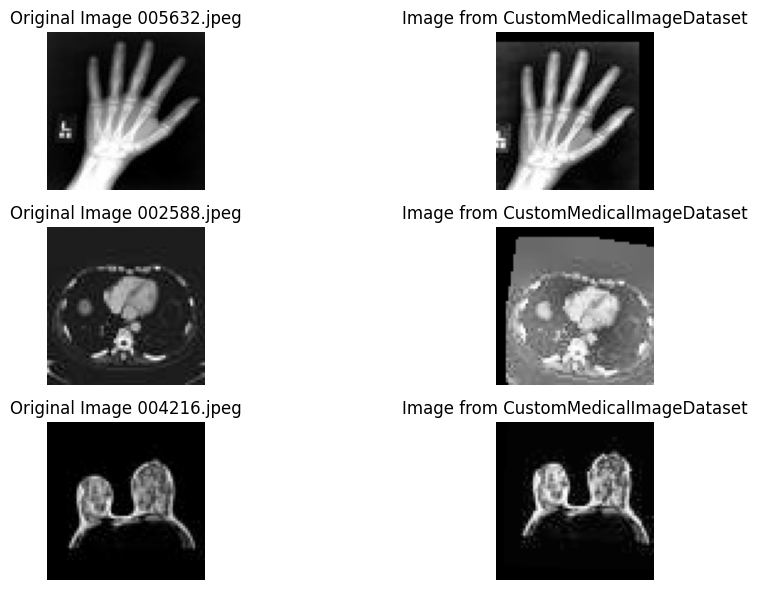

In [70]:
num_samples_to_show = 3
original_image_paths, enhanced_image_tensors = \
    train_data_custom.get_random_samples_for_display(num_samples=num_samples_to_show)

print(f"\nFetched {len(original_image_paths)} random samples for display.")

# --- Display the image pairs ---
display_image_pairs(original_image_paths, enhanced_image_tensors)

We can see contrast enhancement and some small rotations/translations on the images from the CustomMedicalImageDataset.

Next step is turning images from our custom dataset to DataLoader PyTorch class, needed for model training.

In [71]:
import os
from torch.utils.data import DataLoader
BATCH_SIZE=8
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

The model is simple convolutional network, with very few convolutional layers, and standard ReLU activation function.

In [72]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), # 64x64 -> 64x64
            nn.ReLU(),
            # MaxPool2d: Reduces spatial dimensions by factor of 2.
            nn.MaxPool2d(kernel_size=2, stride=2),    # 64x64 -> 32x32

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 32x32 -> 32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # 32x32 -> 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 16x16 -> 16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # 16x16 -> 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 8x8 -> 8x8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)     # 8x8 -> 4x4
        )
        # Calculate the output size of the last pooling layer
        # For 64x64 input and 4 max pools of 2x2, the size will be 4x4
        # (128 channels * 4 * 4)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # 256 is  a hyperparameter, a larger number would give model
            # more parameters, increasing training time
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5), # Add dropout for regularization
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [73]:
model_0 = SimpleCNN()
model_0

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=6, bias=True)
  )
)

We can also see layers and number of parameters of the model using torchinfo.

In [74]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 1, 64, 64]) # do a test pass through with an example input size

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 6]                    --
├─Sequential: 1-1                        [1, 128, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 16, 64, 64]           160
│    └─ReLU: 2-2                         [1, 16, 64, 64]           --
│    └─MaxPool2d: 2-3                    [1, 16, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 32, 32, 32]           4,640
│    └─ReLU: 2-5                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-6                    [1, 32, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 64, 16, 16]           18,496
│    └─ReLU: 2-8                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-9                    [1, 64, 8, 8]             --
│    └─Conv2d: 2-10                      [1, 128, 8, 8]            73,856
│    └─ReLU: 2-11                        [1, 128, 8, 8]            --
│  

Defining train and test step.

In [75]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [76]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Installing early_stopping_pytorch: https://github.com/Bjarten/early-stopping-pytorch, used to avoid overfitting on the training dataset, by keeping track of the validation loss. If the loss stops decreasing for several epochs in a row the training stops.

In [77]:
!pip install early_stopping_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [78]:
# import EarlyStopping
from early_stopping_pytorch import EarlyStopping

In [79]:
from tqdm import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          patience: int,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

        # early_stopping needs the test loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(test_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # 6. Return the filled results at the end of the epochs
    return results

Training the model.

In [80]:
# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of SimpleCNN
model_0 = SimpleCNN().to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# early stopping patience, how many epochs we want to wait after the
# last time the validation loss improved before breaking the training loop
patience = 2

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        patience=patience,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [05:26<49:02, 326.95s/it]

Epoch: 1 | train_loss: 0.0625 | train_acc: 0.9796 | test_loss: 0.0119 | test_acc: 0.9964
Validation loss decreased (inf --> 0.011915).  Saving model ...


 20%|██        | 2/10 [10:53<43:31, 326.45s/it]

Epoch: 2 | train_loss: 0.0169 | train_acc: 0.9957 | test_loss: 0.0039 | test_acc: 0.9991
Validation loss decreased (0.011915 --> 0.003875).  Saving model ...


 30%|███       | 3/10 [16:22<38:14, 327.83s/it]

Epoch: 3 | train_loss: 0.0142 | train_acc: 0.9969 | test_loss: 0.0027 | test_acc: 0.9993
Validation loss decreased (0.003875 --> 0.002726).  Saving model ...


 40%|████      | 4/10 [22:08<33:29, 334.90s/it]

Epoch: 4 | train_loss: 0.0133 | train_acc: 0.9969 | test_loss: 0.0017 | test_acc: 0.9993
Validation loss decreased (0.002726 --> 0.001655).  Saving model ...


 50%|█████     | 5/10 [27:51<28:09, 337.99s/it]

Epoch: 5 | train_loss: 0.0100 | train_acc: 0.9983 | test_loss: 0.0022 | test_acc: 0.9994
EarlyStopping counter: 1 out of 2


 60%|██████    | 6/10 [33:37<22:42, 340.73s/it]

Epoch: 6 | train_loss: 0.0101 | train_acc: 0.9981 | test_loss: 0.0016 | test_acc: 0.9993
Validation loss decreased (0.001655 --> 0.001641).  Saving model ...


 70%|███████   | 7/10 [39:37<17:20, 346.99s/it]

Epoch: 7 | train_loss: 0.0078 | train_acc: 0.9986 | test_loss: 0.0024 | test_acc: 0.9995
EarlyStopping counter: 1 out of 2


 70%|███████   | 7/10 [45:36<19:32, 390.89s/it]

Epoch: 8 | train_loss: 0.0103 | train_acc: 0.9981 | test_loss: 0.0160 | test_acc: 0.9976
EarlyStopping counter: 2 out of 2
Early stopping
Total training time: 2736.220 seconds


In [81]:
model_0_results

{'train_loss': [0.062455703657912184,
  0.01692570966116861,
  0.014221714951710047,
  0.013272725552518518,
  0.009957257607178763,
  0.01011618767949181,
  0.007798355914048883,
  0.010284971574533654],
 'train_acc': [0.9795503004458228,
  0.9957356076759062,
  0.9968986237642954,
  0.9969470827679783,
  0.9982554758674161,
  0.998085869354526,
  0.9986431478968792,
  0.9981100988563675],
 'test_loss': [0.011914848406664263,
  0.003875197269444519,
  0.00272621148270224,
  0.0016547739829326827,
  0.002242804322214506,
  0.0016412887866514628,
  0.002416371962528469,
  0.015950799919231408],
 'test_acc': [0.996353459972863,
  0.9990671641791045,
  0.9993215739484396,
  0.9993215739484396,
  0.9994063772048847,
  0.9993215739484396,
  0.9994911804613297,
  0.9976255088195387]}

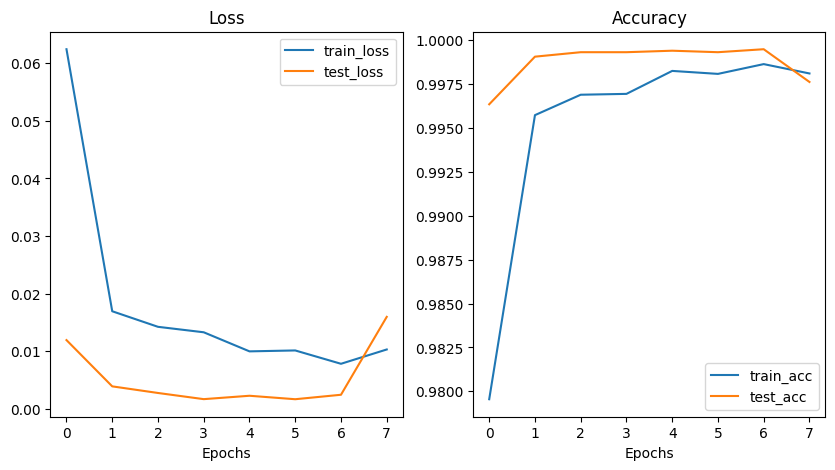

In [82]:
# Plot the loss curves

def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(10,5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_acc')
  plt.plot(epochs, test_accuracy, label='test_acc')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


plot_loss_curves(model_0_results)

Accuracy and loss curves of the model's results look good, so let's plot model's predictions for random images in validate dataset, the images that model hasn't seen.

In [83]:
import torchvision

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform: transforms.Compose = None,
                        device: torch.device = None):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image using OpenCV, as grayscale
    original_img_cv = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

    if original_img_cv is None:
        print(f"Warning: Could not load image from {image_path}. Cannot predict.")
        return

    # 2. Apply OpenCV contrast enhancement (CLAHE), as in CustomMedicalImageDataset
    if original_img_cv.size > 0:
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(4,4))
        img_enhanced_cv = clahe.apply(original_img_cv)
    else:
        img_enhanced_cv = original_img_cv # Use original empty image if it's empty

    # 3. Convert to PIL Image for torchvision transforms
    img_pil = Image.fromarray(img_enhanced_cv)

    # 4. Apply PyTorch transforms
    if transform:
        target_image_tensor = transform(img_pil)
    else:
        target_image_tensor = transforms.ToTensor()(img_pil)


    # 5. Ensure model is on device
    model.to(device)

    # 6. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image (batch dimension)
        target_image_tensor = target_image_tensor.unsqueeze(dim=0)

        # Make a prediction on image and send it to the target device
        target_image_pred = model(target_image_tensor.to(device))

    # 7. Fetch prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 8. Fetch prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(img_pil, cmap='gray')

    if class_names:
        title = (f"Pred: {class_names[target_image_pred_label.cpu()]} | "
                 f"Prob: {target_image_pred_probs.max().cpu():.3f}")
    else:
        title = (f"Pred: {target_image_pred_label.cpu().item()} | "
                 f"Prob: {target_image_pred_probs.max().cpu():.3f}")
    plt.title(title)
    plt.axis(False)

Randomly selected image path: data/medical-mnist/val/AbdomenCT/007505.jpeg
Extracted image class: AbdomenCT


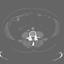

In [84]:
data_root = Path("data/medical-mnist")
validate_dir = data_root / "val"

img = get_random_image(validate_dir)
img

In [96]:
custom_image_path, custom_image_class = get_random_image_path(validate_dir)
custom_image = Image.open(custom_image_path)
class_names=train_data_custom.classes
print(f"Custom image class: {custom_image_class} from {class_names}")

Randomly selected image path: data/medical-mnist/val/CXR/007082.jpeg
Extracted image class: CXR
Custom image class: CXR from ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


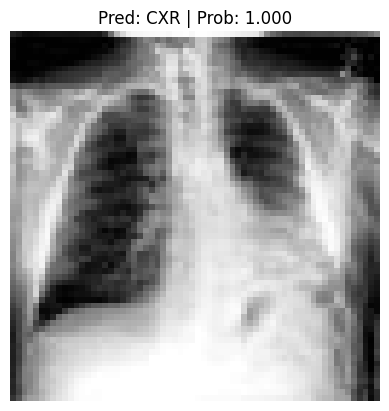

In [97]:
test_val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=test_val_transforms,
                    device=device)

Randomly selected image path: data/medical-mnist/val/HeadCT/004053.jpeg
Extracted image class: HeadCT
Custom image class: HeadCT from ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


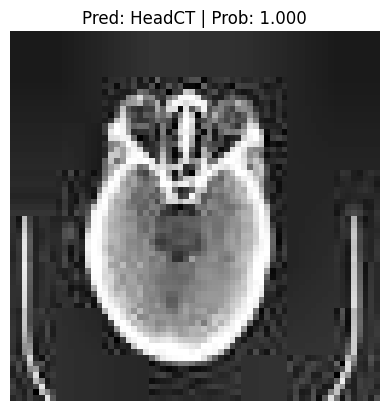

In [188]:
# Let's do some more checking
custom_image_path, custom_image_class = get_random_image_path(validate_dir)
custom_image = Image.open(custom_image_path)
class_names=train_data_custom.classes
print(f"Custom image class: {custom_image_class} from {class_names}")

# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=test_val_transforms,
                    device=device)

The final step is calculating confusion matrix to evaluate the performance of our model.

In [125]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report

def calculate_confusion_matrix(model: torch.nn.Module,
                               val_directory: str,
                               batch_size: int,
                               num_workers: int,
                               transform: transforms.Compose,
                               device: torch.device):
    """
    Calculates the confusion matrix and other metrics for a dataset.
    """
    # Create a dataset and DataLoader for the validation data
    val_data = CustomMedicalImageDataset(val_directory, transform)
    val_dataloader = DataLoader(dataset=val_data,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers)

    num_classes = len(val_data.classes)
    class_names = val_data.classes

    all_preds = []
    all_labels = []

    model.eval()
    model.to(device) # Ensure model is on device before inference
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            # Forward pass
            y_logits = model(X)
            # Get predictions (class with highest logit)
            predictions = y_logits.argmax(dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Calculate confusion matrix using sklearn
    conf_matrix = confusion_matrix(y_true=all_labels,
                                   y_pred=all_preds,
                                   labels=np.arange(num_classes))

    correct_predictions = np.trace(conf_matrix) # Sum of diagonal elements
    total_predictions = np.sum(conf_matrix)

    print(f"\n--- Confusion Matrix and Classification Report ---")
    print(f"Correct predictions: {correct_predictions} of {total_predictions}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClass Names (Order: Rows/Cols correspond to this list):")
    print(class_names)
    print(f"Overall Accuracy: {(correct_predictions / total_predictions * 100):.2f}%")

    # Generate a detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_true=all_labels,
                                labels=np.arange(num_classes),
                                y_pred=all_preds,
                                target_names=class_names,
                                zero_division='warn')) # 'warn' or 0

    return conf_matrix, class_names

conf_matrix, class_names_ordered = calculate_confusion_matrix(
    model=model_0,
    val_directory=validate_dir,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    transform=test_val_transforms,
    device=device
)


--- Confusion Matrix and Classification Report ---
Correct predictions: 5890 of 5897

Confusion Matrix:
[[1000    0    0    0    0    0]
 [   0  897    0    0    0    0]
 [   0    0  996    0    2    2]
 [   0    0    0 1000    0    0]
 [   0    0    0    1  997    2]
 [   0    0    0    0    0 1000]]

Class Names (Order: Rows/Cols correspond to this list):
['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Overall Accuracy: 99.88%

Classification Report:
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00      1000
   BreastMRI       1.00      1.00      1.00       897
         CXR       1.00      1.00      1.00      1000
     ChestCT       1.00      1.00      1.00      1000
        Hand       1.00      1.00      1.00      1000
      HeadCT       1.00      1.00      1.00      1000

    accuracy                           1.00      5897
   macro avg       1.00      1.00      1.00      5897
weighted avg       1.00      1.00      

From the confusion matrix and classification report we can conclude that the features of the different image classes, 'AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT' are very prominent, since even with the simple convolutional network we get such high accuracy.